In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy.signal
%config InlineBackend.figure_format='retina'

In [21]:
def load_dataset(filename, which_channels = ["0_8","0_20"], noise_reject_rate = 0.01):
    """
    Load DT5550W DAQ dataset (processing mode = "FULL")
    
    Inputs
    -------
    filename: str
        Filename path
    which_channels: list or "auto"
        If which_channels is list, read the sepcified channels
        If which_channels is "auto", find active channels 
    noise_reject_rate: float in [0,1]
        The percentage of events needed to be identified as active channels, required only when which_channels is "auto"
        
    Returns
    -------
    df: Pandas dataframe
    """
    cols_list = pd.read_csv(filename, nrows=0).columns.tolist()[0].split(sep=";")
    #metadata_name = cols_list[:10]+cols_list[int(len(cols_list)/2+2):int(len(cols_list)/2+8)]
    metadata_name = cols_list[:10]
    dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_","RELATIVETIME_"]
    #dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_",]
    if which_channels == "auto": #Auto find active channels
        ch_hit =[]
        for i in range(32):
            ch_hit.append("HIT_0_{0}".format(i))
            ch_hit.append("HIT_1_{0}".format(i))
        hit_df = pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=ch_hit).fillna(0).to_numpy()
        ch_list = np.argwhere(np.sum(hit_df, axis = 0) > noise_reject_rate*len(hit_df))
        which_channels = []
        for index in ch_list:
            if index >= 32:
                which_channels.append("1_{0}".format(index[0]-32))
            else:
                which_channels.append("0_{0}".format(index[0]))
    data_ch = []
    for channels in which_channels:
        for ch_name in dtype_list:
            data_ch.append(ch_name+channels)
    return pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=metadata_name+data_ch)


def find_alpha(df, channels = ['FINE_0_8', 'FINE_0_26']):
    """
    FInd the calibration parameters for channels
    
    Inputs
    -------
    df: Dict
        A dictionary from Pandas dataframe for DT5550W DAQ dataset

    channels: list
        Channels to calibrate
    
    Returns
    -------
    alpha: list
        calibration constent for channels
    """
    
    alpha = np.zeros(len(channels))
    for i,ch in enumerate(channels):
        mask = (np.array(df[ch]) > 5)& (np.array(df[ch]) < 1000) #remove fine time = 4, 1020 events
        print(np.min(np.array(df[ch])[mask]))
        print(np.max(np.array(df[ch])[mask]))
        alpha[i] = 25/(np.max(np.array(df[ch])[mask])-np.min(np.array(df[ch])[mask]))
    return alpha


def finetime_calib(times, low=None, high=None):
    if low is None:
        times = np.array(times)
        mask = (times > 4)& (times < 1000)
        low = np.min(times[mask])
        high=np.max(times[mask])
        
    total_uncalib = high-low
    finetime_calib = (times-low)/total_uncalib*25
    
    return finetime_calib

def load_finetime(filename, ch ="0", ftime_min=None, ftime_max=None, finetime_roll=0):
    data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_"+ch, "FINE_"+ch,"RUN_EventTimecode_ns"])
    data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
    
    if finetime_roll!=0:
        data[f"FINE_calib_{ch}"]= (data[f"FINE_calib_{ch}"]+finetime_roll)%25    
    return data


def process_inl(finetimes):
    # One bin per ADU
    nbins = 1+len(np.unique(finetimes))
    n,ibins = np.histogram(finetimes, bins=np.linspace(0,25,nbins));
    # Normalize              
    n=n/np.sum(n)

    binedge_right = ibins[1:]
    cdf = np.cumsum(n)
    truth_time = cdf*25

    truth_to_measured = scipy.interpolate.interp1d(truth_time, binedge_right)
    truth_grid = np.linspace(np.min(truth_time), np.max(truth_time), 1000)
    measured = truth_to_measured(truth_grid)
    residual = measured-truth_grid
    return residual

def plot_charge_time(filename, charge_cut_threshold=0, title_text=None, finetime_roll=0):

    data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
    ch = "0"
    data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
    
    if finetime_roll!=0:
        data[f"FINE_calib_{ch}"]= (data[f"FINE_calib_{ch}"]+finetime_roll)%25
    # data[f"FINE_calib_{ch}"] = data[f"FINE_{ch}"]/1024*25

    threshold=charge_cut_threshold

    hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
    hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>threshold],bins=1023,range=(0,1023),histtype="step");
    # yscale("log")
    xlabel("Charge [ADU]")
    yscale("log")
    if title is not None:
        title(title_text)
    show()

    ft_plot = data[f"FINE_calib_{ch}"][data["CHARGE_0"]>threshold]
    ft_mean = np.mean(ft_plot)
    ft_std = np.std(ft_plot)
    ft_std = max([0.1,ft_std])
    range_low = np.max([0, ft_mean-15*ft_std])
    range_high = np.min([25, ft_mean+15*ft_std])
    bins=np.linspace(range_low,range_high,50)
    bins_fit=np.linspace(range_low,range_high,300)
    # bins=np.linspace(5,14,60)

    n,ibins,_ = hist(ft_plot, bins=bins,label="", density=0, histtype="step", color="C1");
    # n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1

    popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(ft_mean-5*ft_std,ft_mean+5*ft_std))
    perr1 = np.sqrt(np.diag(pcov))
    print(popt1[2],'[ns]')
    plot(bins_fit, util.Utils.Gauss(bins_fit,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns" )
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

    xlabel("Fine time [ns]")
    ylabel("Normalized counts")
    legend(fontsize=11)
    if title is not None:
        title(title_text)
    show()
    # yscale("log")
    
def fit_finetime(finetimes, charge_cut_threshold=0, title_text=None, finetime_roll=0, color="C0"):
    ft_plot = finetimes
    ft_mean = np.mean(ft_plot)
    ft_std = np.std(ft_plot)
    ft_std = max([0.1,ft_std])
    range_low = np.max([0, ft_mean-15*ft_std])
    range_high = np.min([25, ft_mean+15*ft_std])
    bins=np.linspace(range_low,range_high,50)
    bins_fit=np.linspace(range_low,range_high,300)
    # bins=np.linspace(5,14,60)

    n,ibins,_ = hist(ft_plot, bins=bins,label="", density=0, histtype="step", color=color);
    # n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1

    popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(ft_mean-5*ft_std,ft_mean+5*ft_std))
    perr1 = np.sqrt(np.diag(pcov))
    print(popt1[2],'[ns]')
    plot(bins_fit, util.Utils.Gauss(bins_fit,*popt1),color=color,linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns" )
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

    xlabel("Fine time [ns]")
    ylabel("Normalized counts")
    legend(fontsize=11)
    if title is not None:
        title(title_text)
    # yscale("log")    

In [4]:
DATA_DIR = "E:\\sync\\DT5550W\\"

In [6]:
# filename = "{DATA_DIR}/preamp_out.csv"
# data = np.loadtxt(filename, delimiter = ",",skiprows=1)
# # data = load_dataset(filename, which_channels = ["0_21"])
# # data  = pd.read_csv(filename, sep=',', on_bad_lines  = "skip")

### Get finetime calibration with a different dataset:


In [5]:
filename = f"{DATA_DIR}/15.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch="0"
ftime_min=np.min(data[f"FINE_{ch}"])
ftime_max=np.max(data[f"FINE_{ch}"])

# Inspect one file

In [10]:
filename = f"{DATA_DIR}/42.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)


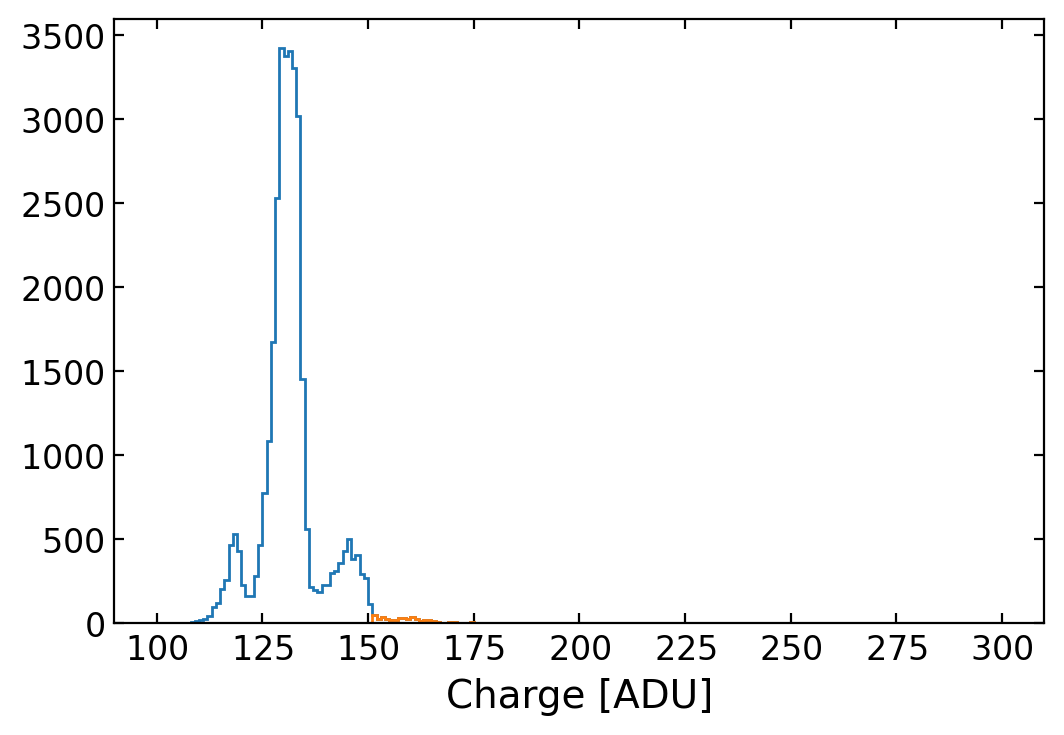

In [17]:
hist(data[f"CHARGE_{ch}"],bins=200,range=(100,300),histtype="step");
n,ibins,p = hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>150],bins=200,range=(100,300),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")

bincenters=0.5*(ibins[1:] + ibins[:-1])

# peaks,info=scipy.signal.find_peaks(n,prominence=1000)
# for peak in peaks:
#     axvline(bincenters[peak])
    
# gap = bincenters[peaks[1]]-bincenters[peaks[0]]
# print(gap)

# stddev_in_npeaks = np.sqrt(np.mean(np.square(data[f"CHARGE_{ch}"][data[f"CHARGE_{ch}"]>175]-175)))/gap
# print("N std dev ", stddev_in_npeaks)

show()

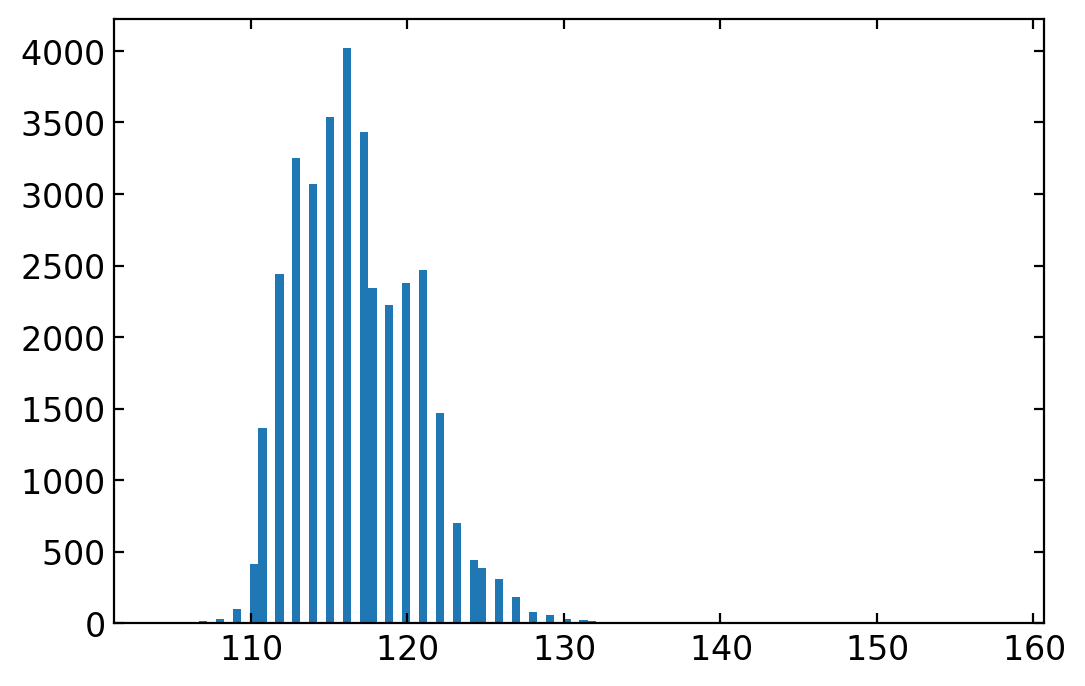

In [14]:
hist(data[f"CHARGE_{ch}"],range=(100,150));

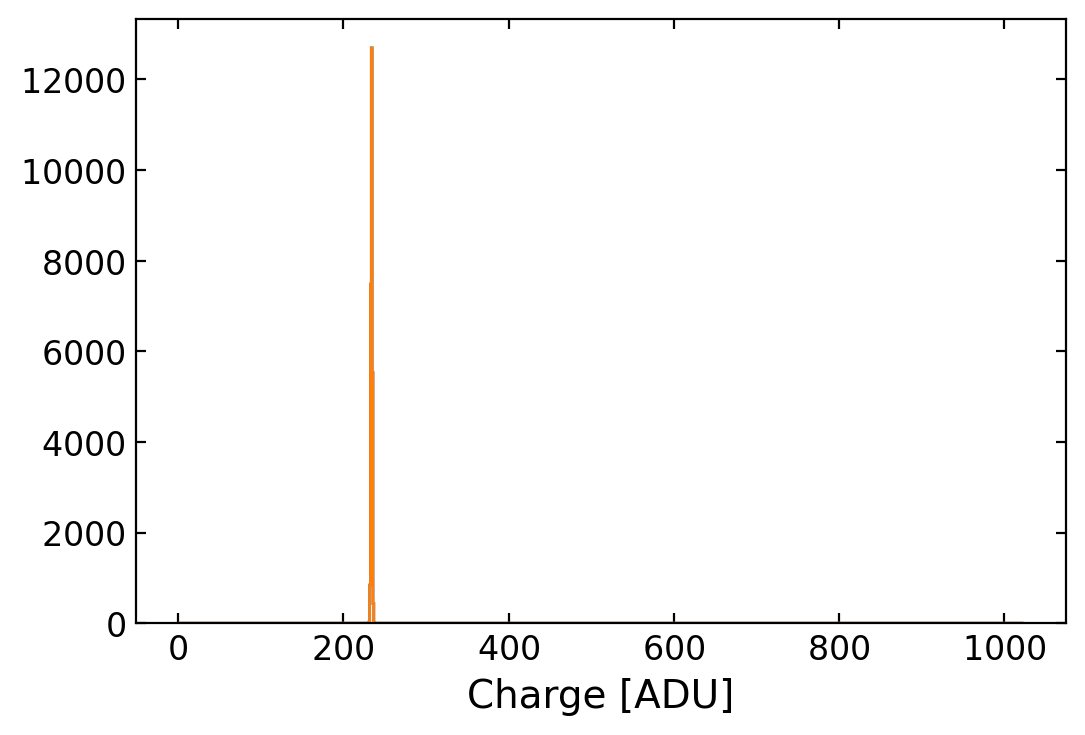

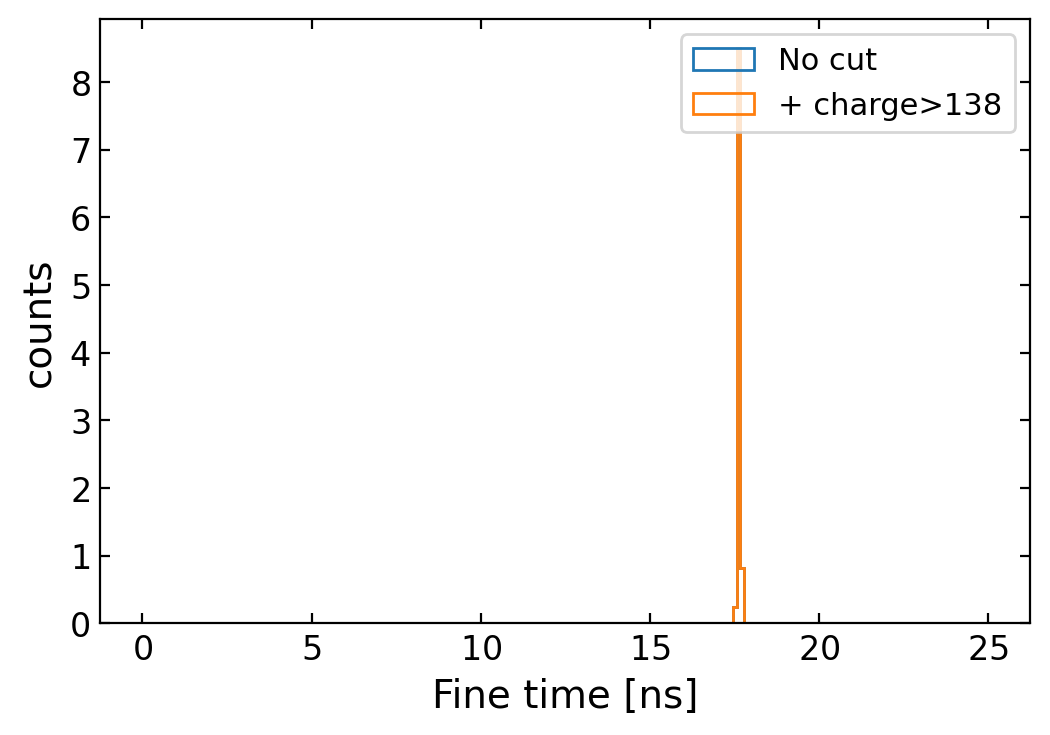

In [30]:
threshold=138
normed=True

hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>threshold],bins=1023,range=(0,1023),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")
show()

bins=np.linspace(0,25,240)
# bins=np.linspace(4,14,60)

n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="No cut", density=normed, histtype="step", color="C0");
n,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>threshold], bins=bins,label=f"+ charge>{threshold}", density=normed, histtype="step", color="C1");
# n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<180], bins=bins,label="Dark current", density=1, histtype="step");
bincenters=0.5*(ibins[1:]+ibins[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

# popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(5,13))
# perr1 = np.sqrt(np.diag(pcov))
# print(popt1[2],'[cm]')
# plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.2f} ns" )
# # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11)
# yscale("log")

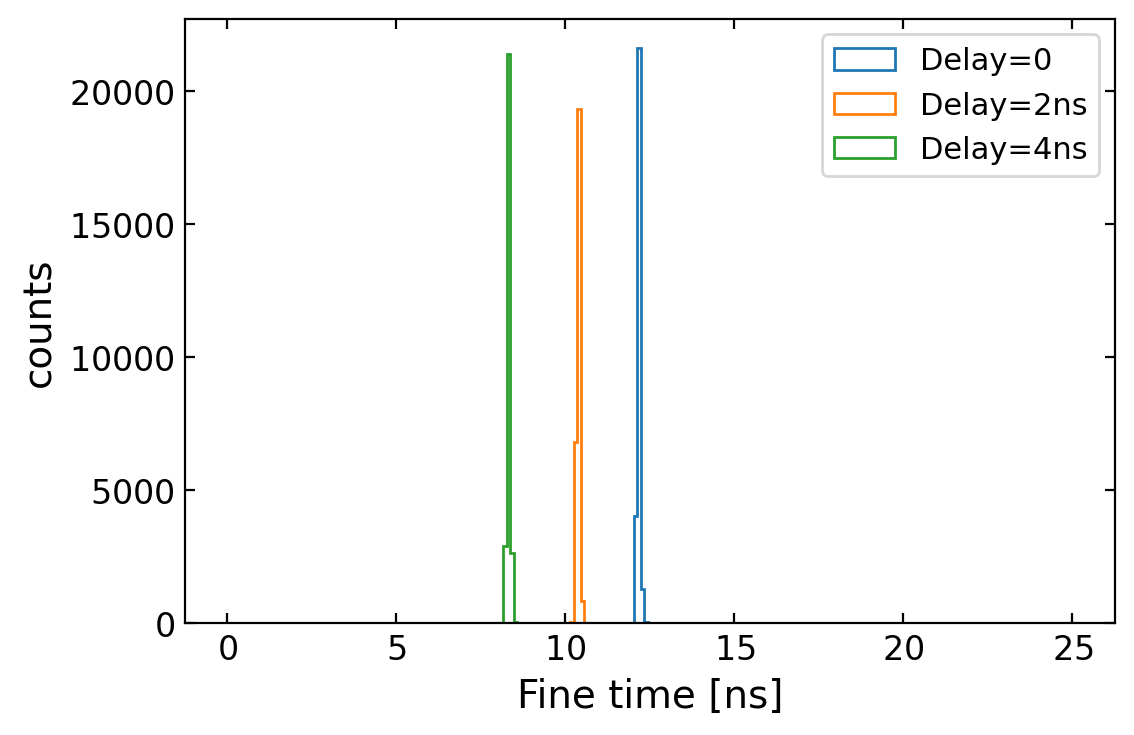

In [18]:
filename = f"{DATA_DIR}/52.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
bins=np.linspace(0,25,240)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Delay=0", density=normed, histtype="step", color="C0");

filename = f"{DATA_DIR}/53.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
bins=np.linspace(0,25,240)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Delay=2ns", density=normed, histtype="step", color="C1");

filename = f"{DATA_DIR}/54.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
bins=np.linspace(0,25,240)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Delay=4ns", density=normed, histtype="step", color="C2");





xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11)


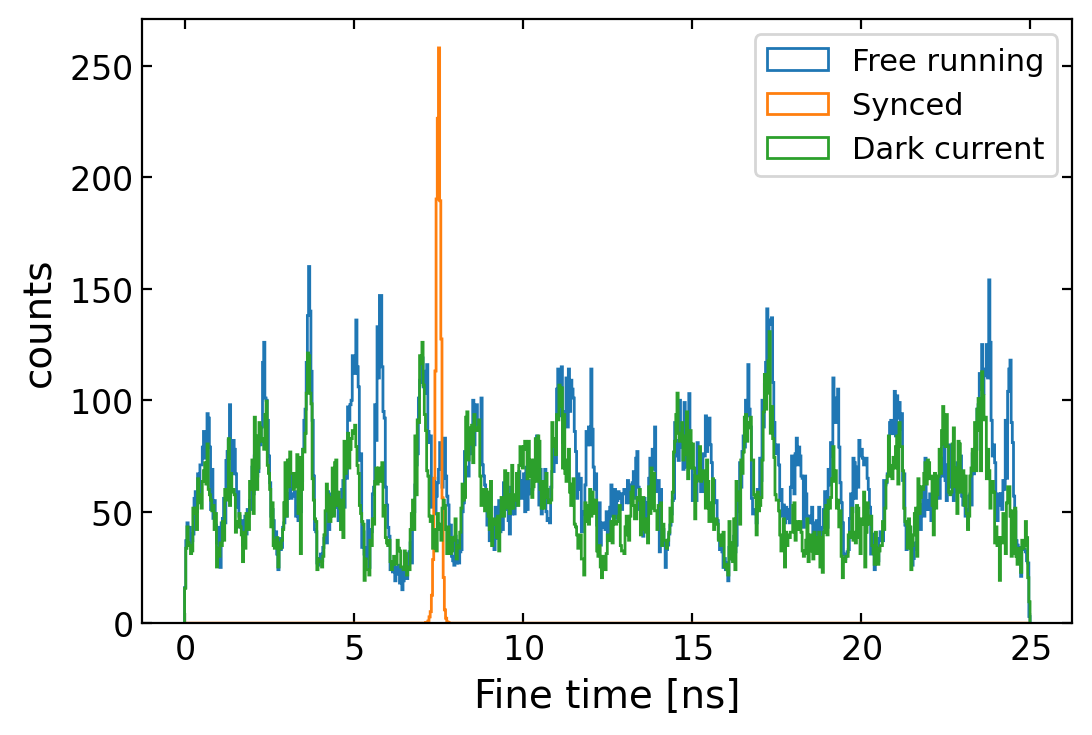

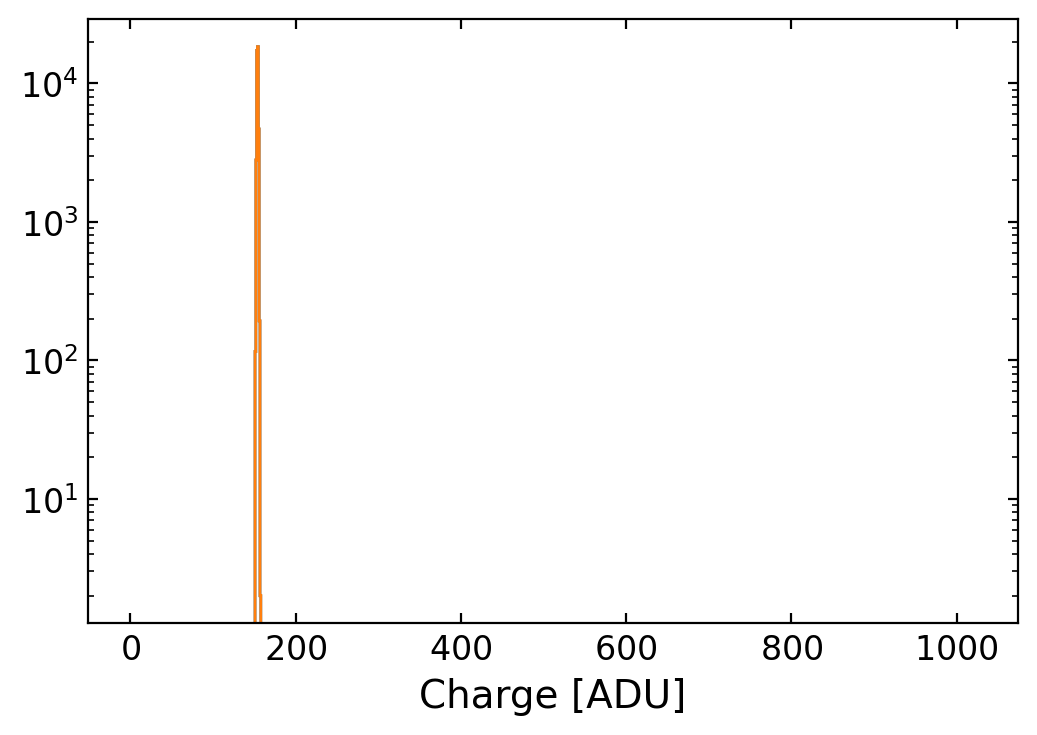

0.0630386656184844 [ns]


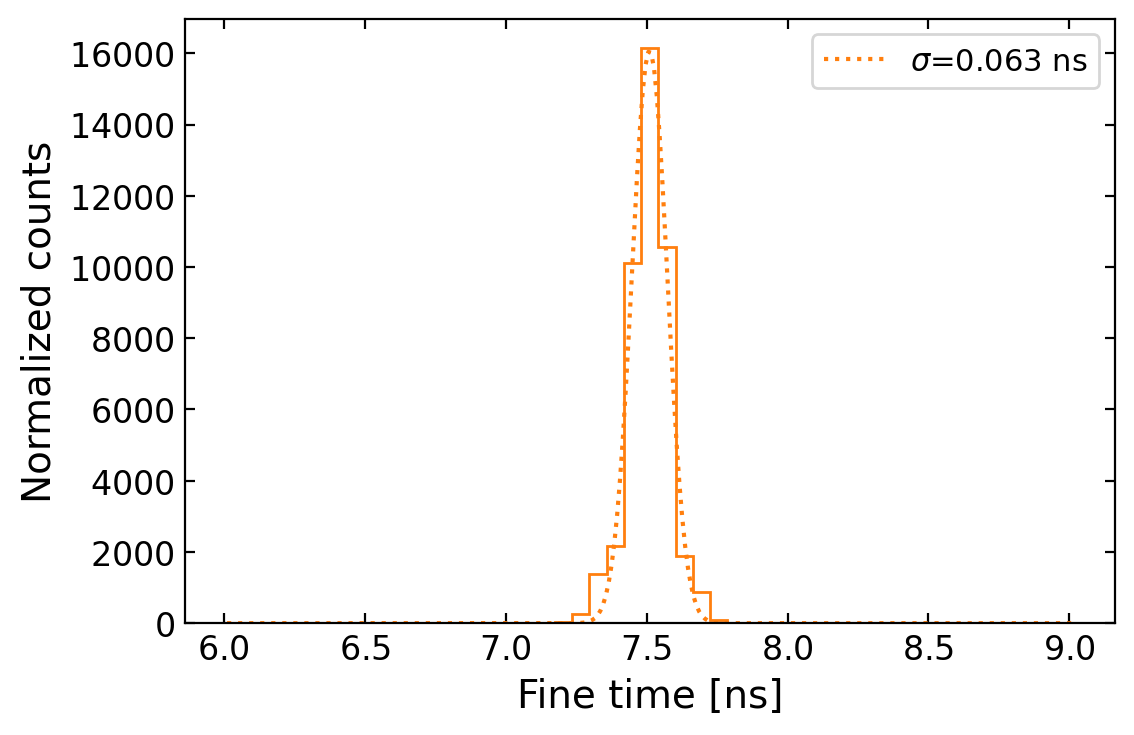

In [25]:
nbins = 1+len(np.unique(data[f"FINE_calib_{ch}"]))
bins=np.linspace(0,25,nbins)
ch="0"
normed=False

data  = load_finetime(f"{DATA_DIR}/55.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n1,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Free running", density=normed, histtype="step", color="C0");

data  = load_finetime(f"{DATA_DIR}/56.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Synced", weights=np.ones_like(data[f"FINE_calib_{ch}"])*0.03, histtype="step", color="C1");


data  = load_finetime(f"{DATA_DIR}/48.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Dark current", weights=np.ones_like(data[f"FINE_calib_{ch}"])*1.2, histtype="step", color="C2");



xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11)
show()

plot_charge_time(f"{DATA_DIR}/56.data", charge_cut_threshold=100, title_text="", finetime_roll=0)


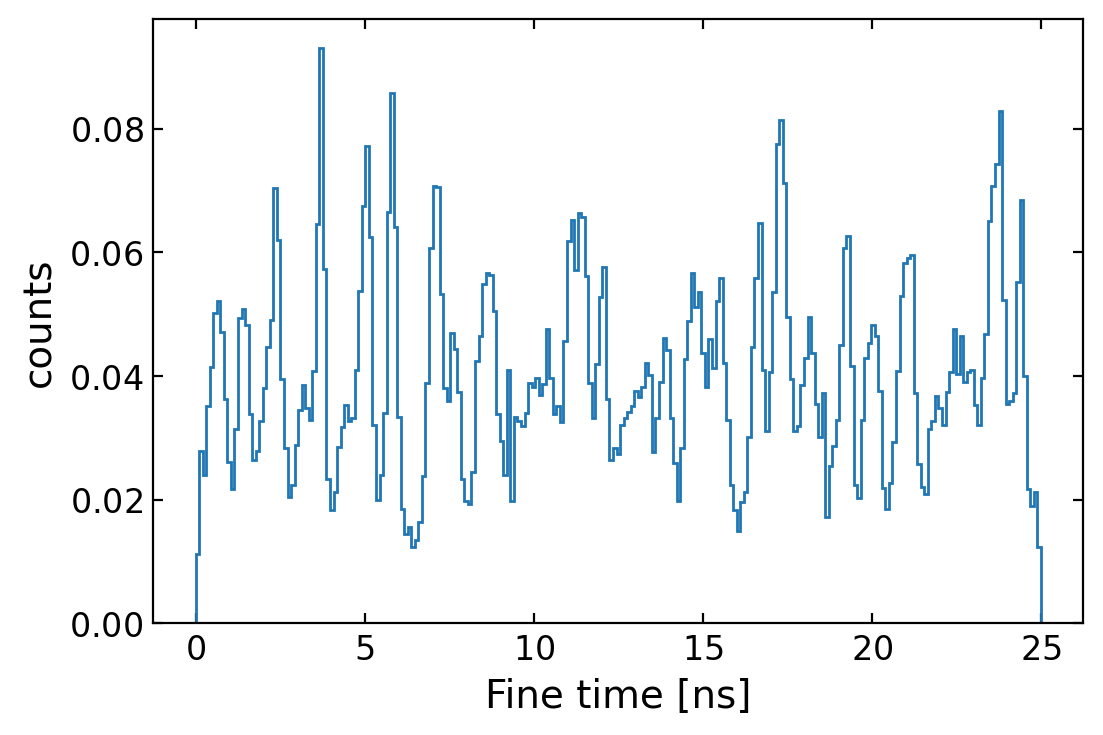

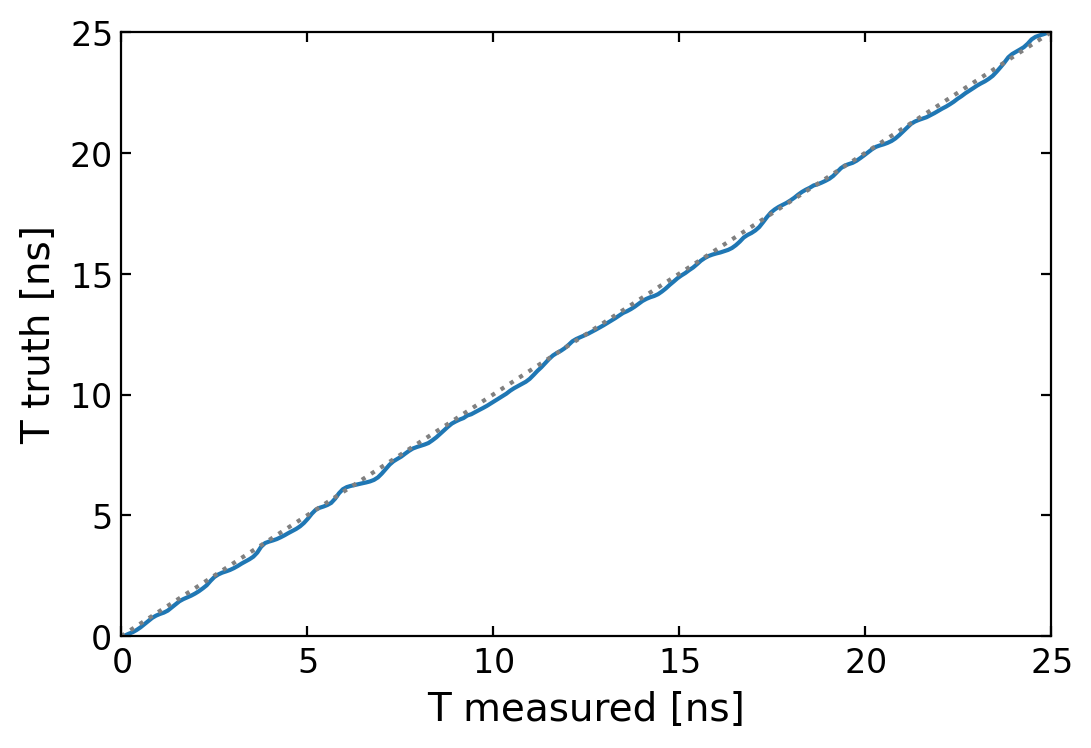

0.12041957249007391 [ns]


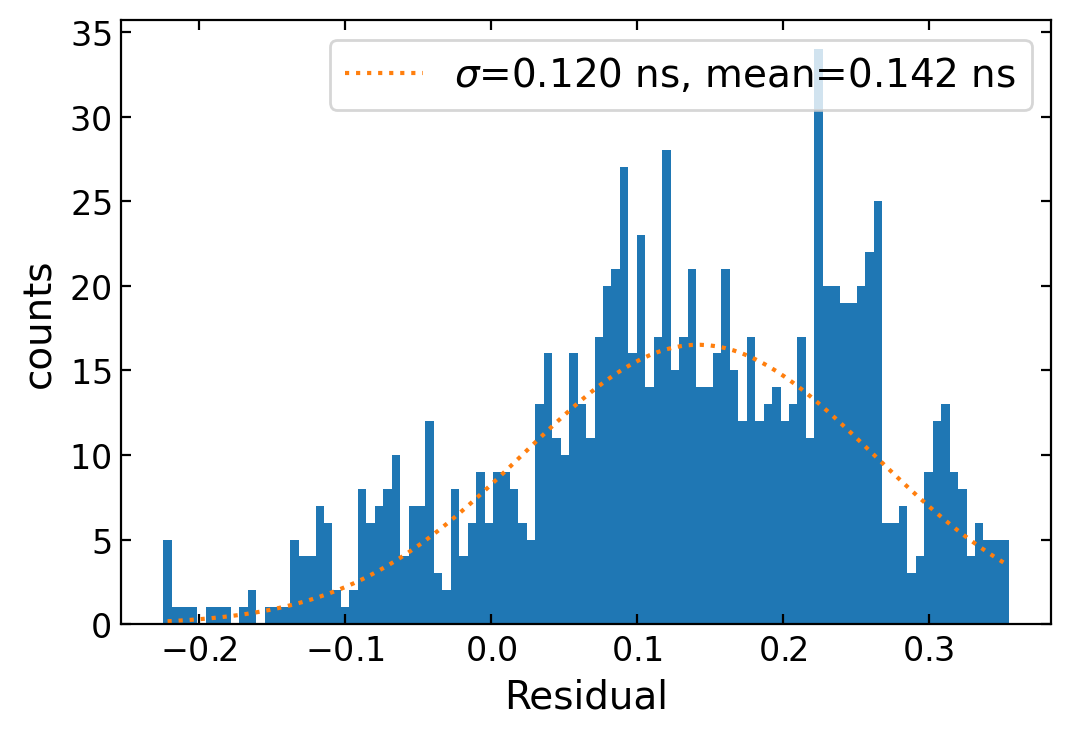

In [72]:
data  = load_finetime(f"{DATA_DIR}/55.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n1,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Free running", density=1, histtype="step", color="C0");
xlabel("Fine time [ns]")
ylabel("counts")
show()


binsize = bins[1]-bins[0]
binedge_right = ibins[1:]
cdf = np.cumsum(n1)
truth_time = cdf*binsize*25

plot(binedge_right, truth_time)
plot([0,25],[0,25],color="grey", linestyle=":")
xlabel("T measured [ns]")
ylabel("T truth [ns]")
xlim(0,25)
ylim(0,25)
show()



truth_to_measured = scipy.interpolate.interp1d(truth_time, binedge_right)
truth_grid = np.linspace(np.min(truth_time), np.max(truth_time), 1000)
measured = truth_to_measured(truth_grid)
residual = measured-truth_grid

n,ibins2,p = hist(residual);

bincenters2=0.5*(ibins2[1:]+ibins2[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

popt1,pcov = rt.fit_tg(bincenters2,n,yerr=yerr,function="gaus",fit_range=(-0.3,0.3))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[ns]')
plot(bincenters2, util.Utils.Gauss(bincenters2,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns, mean={popt1[1]:.3f} ns")
xlabel("Residual")
ylabel("counts")
legend()

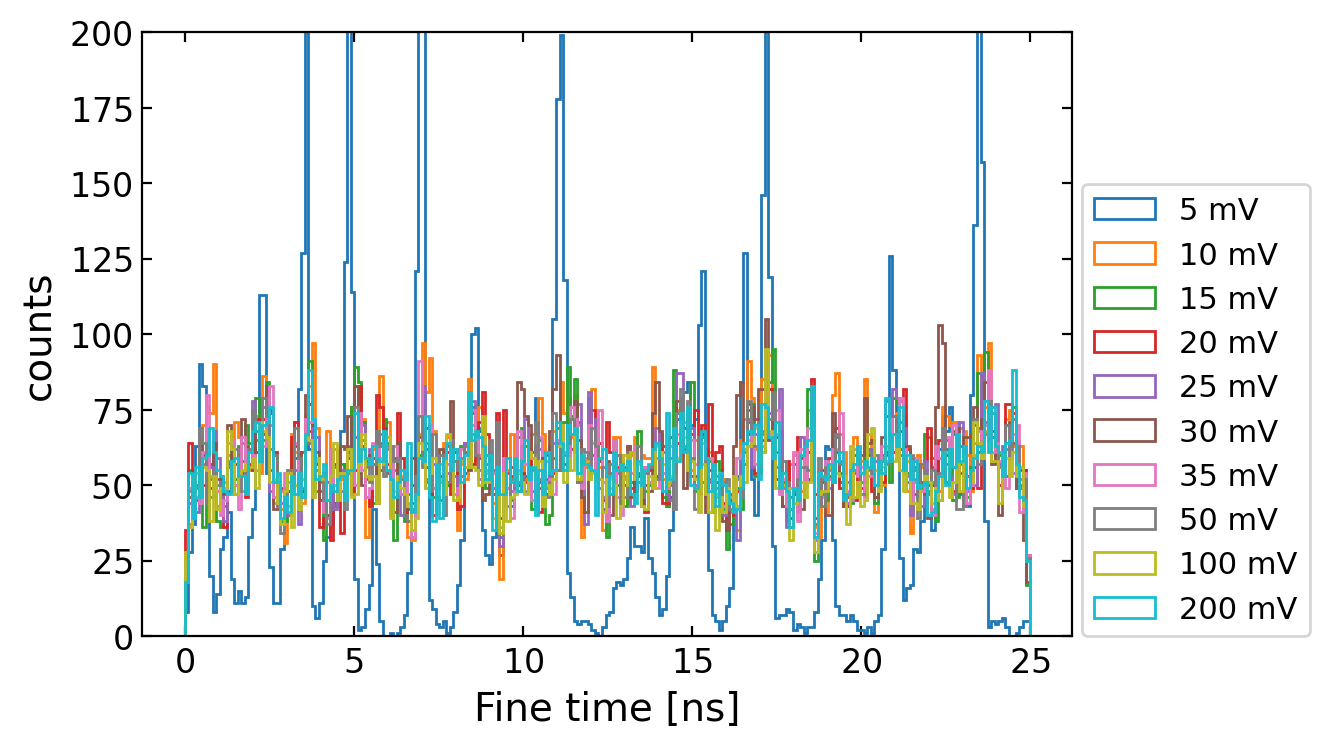

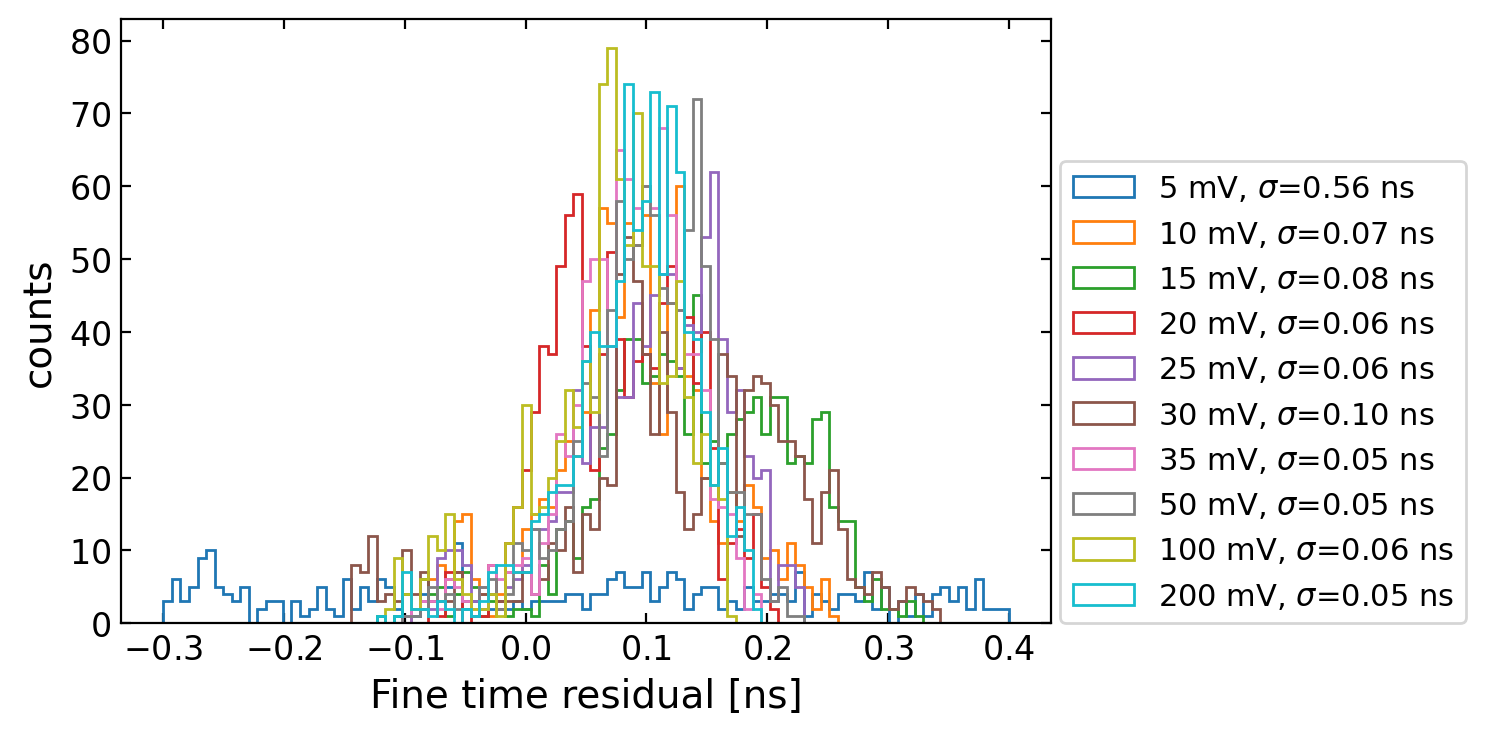

In [69]:
bins=np.linspace(0,25,240)
ch="0"
normed=False

labels = [5,10,15,20,25,30,35,50,100,200]

for i, idata in enumerate(range(57,67)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label=f"{labels[i]} mV", density=normed, histtype="step");


xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
ylim(0,200)
show()



for i, idata in enumerate(range(57,67)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    residuals = process_inl(data[f"FINE_calib_{ch}"])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.4,100), histtype="step",label=f"{labels[i]} mV, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

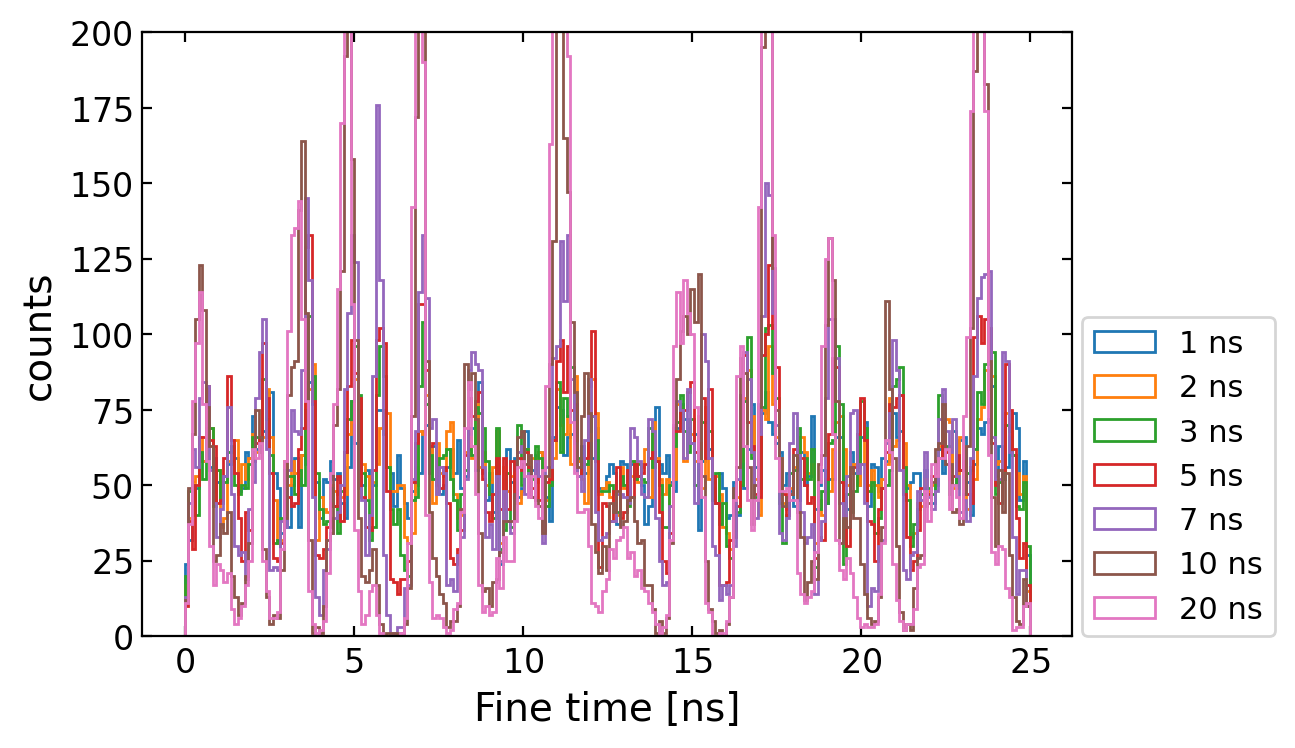

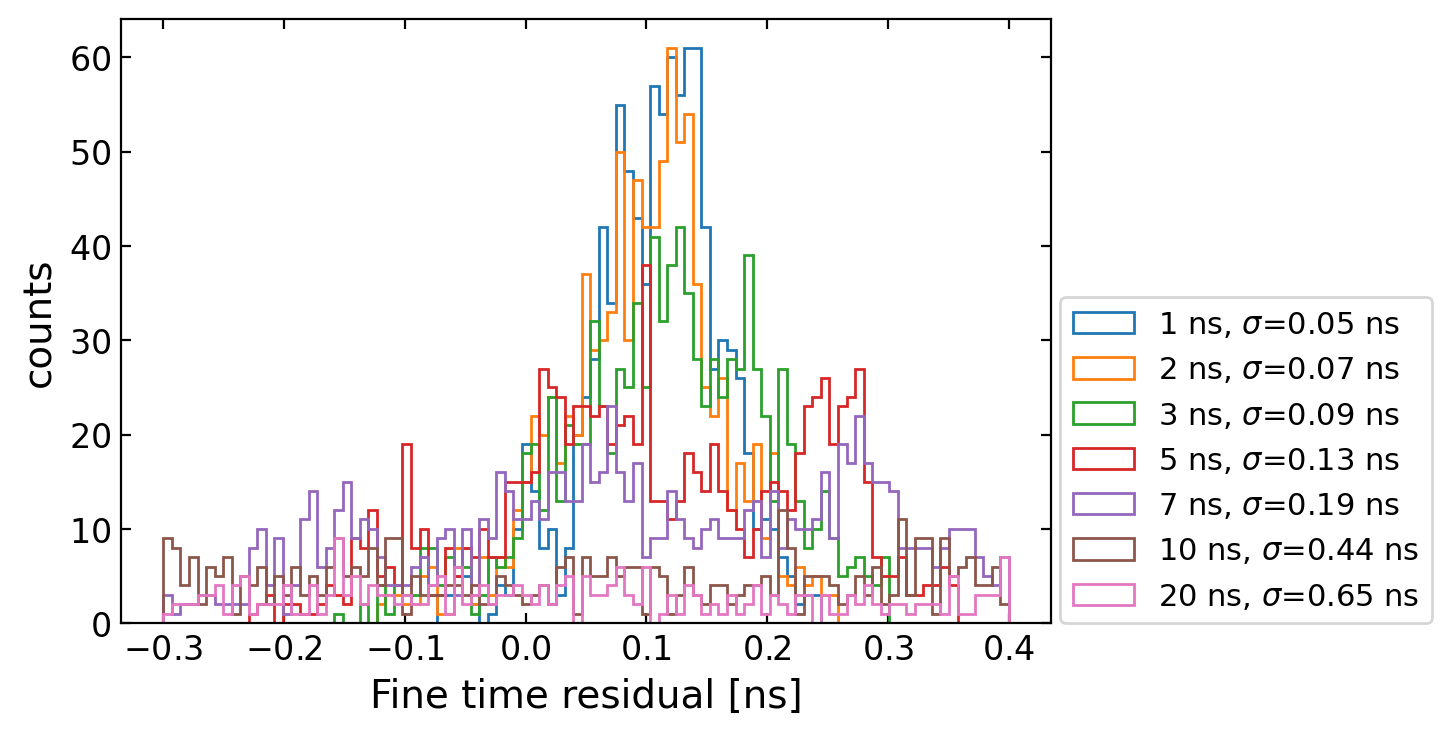

In [71]:
bins=np.linspace(0,25,240)
ch="0"
normed=False

labels = [1, 2, 3, 5, 7, 10, 20]

for i, idata in enumerate(range(67,74)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label=f"{labels[i]} ns", density=normed, histtype="step");


xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
ylim(0,200)
show()



for i, idata in enumerate(range(67,74)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    residuals = process_inl(data[f"FINE_calib_{ch}"])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.4,100), histtype="step",label=f"{labels[i]} ns, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

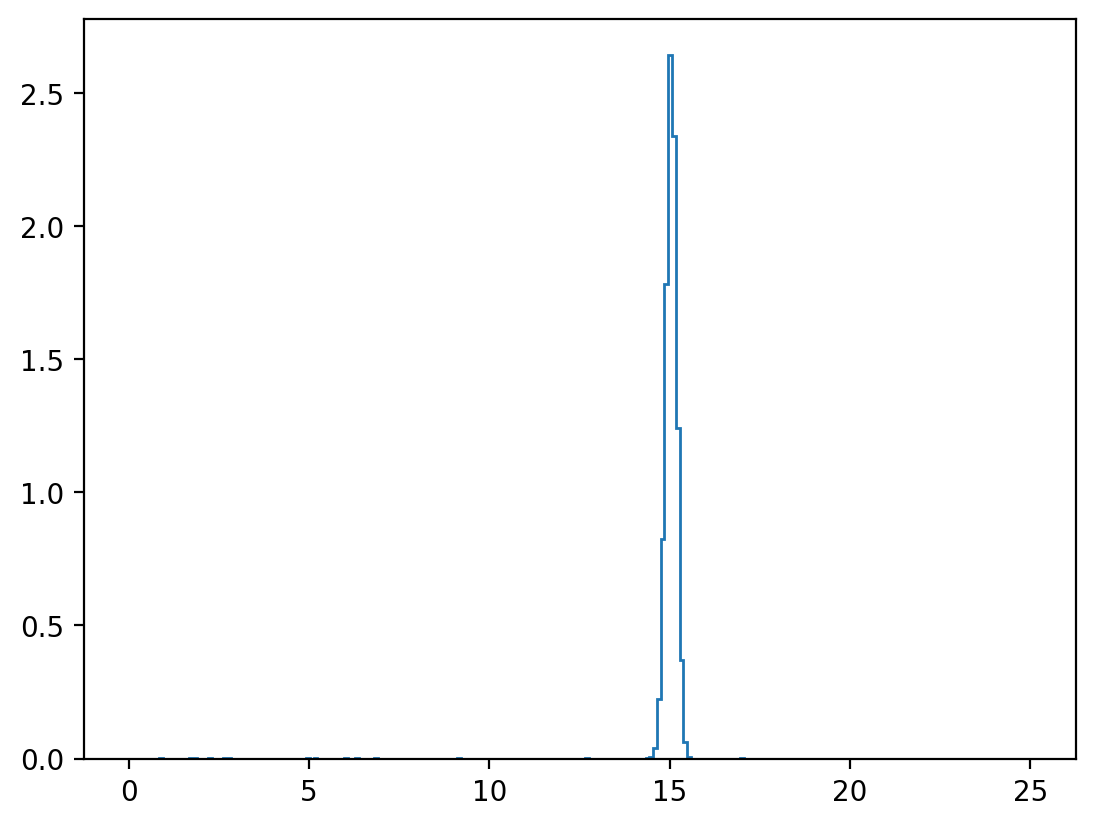

In [19]:
bins=np.linspace(0,25,240)
data  = load_finetime(f"{DATA_DIR}\\116.data", ch =ch, ftime_min=None, ftime_max=None, finetime_roll=0)
mask = (data[f"CHARGE_{ch}"]>75)#&(data[f"CHARGE_{ch}"]<125)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"][mask], bins=bins,label=f" mV", density=1, histtype="step");
    # fit_finetime(data[f"FINE_calib_{ch}"][mask]);

---
# Study

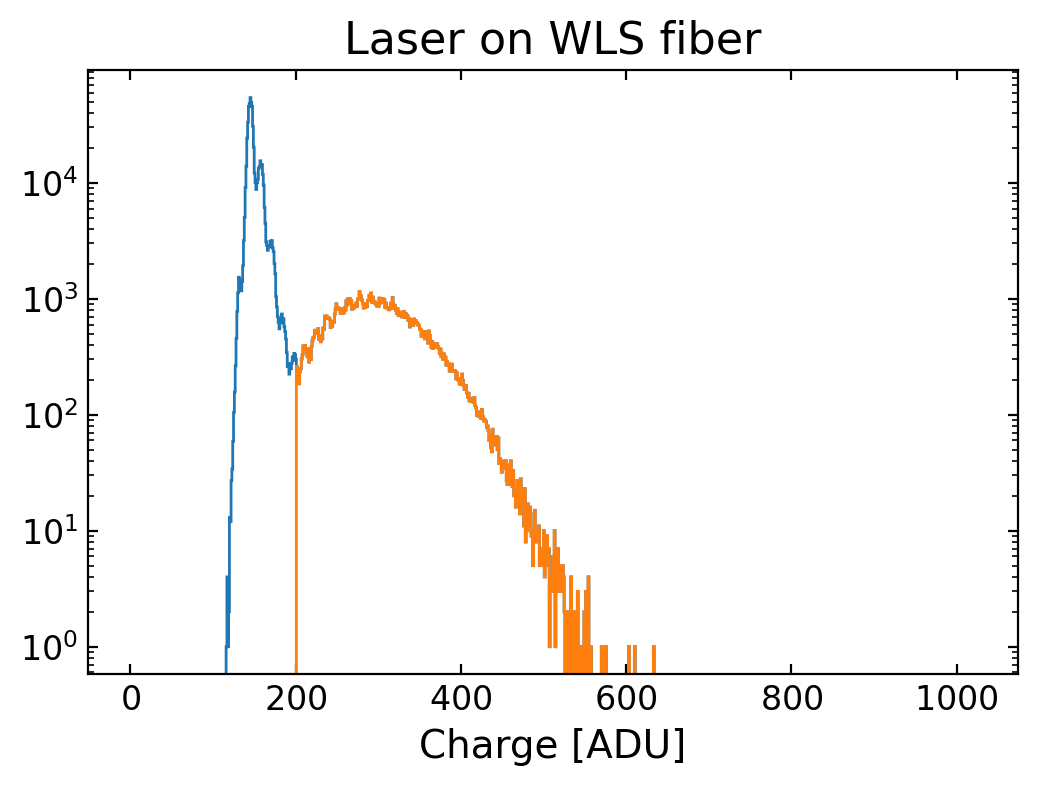

1.512127217071292 [ns]


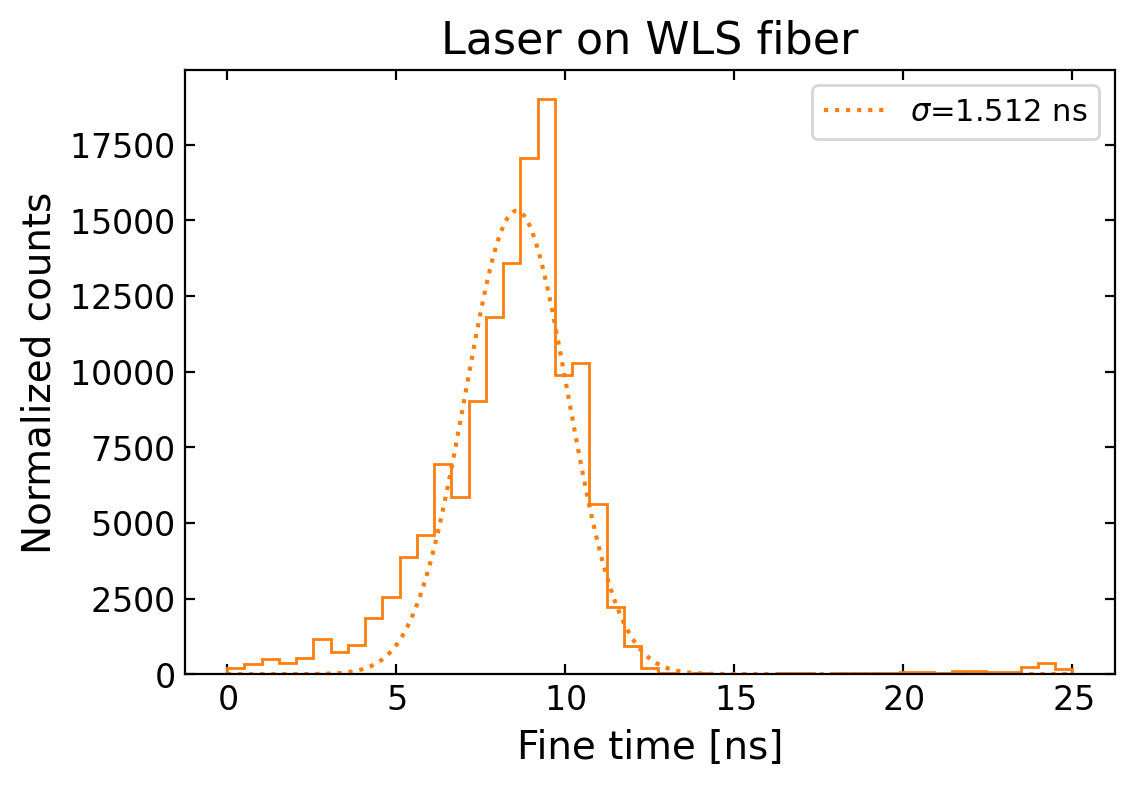

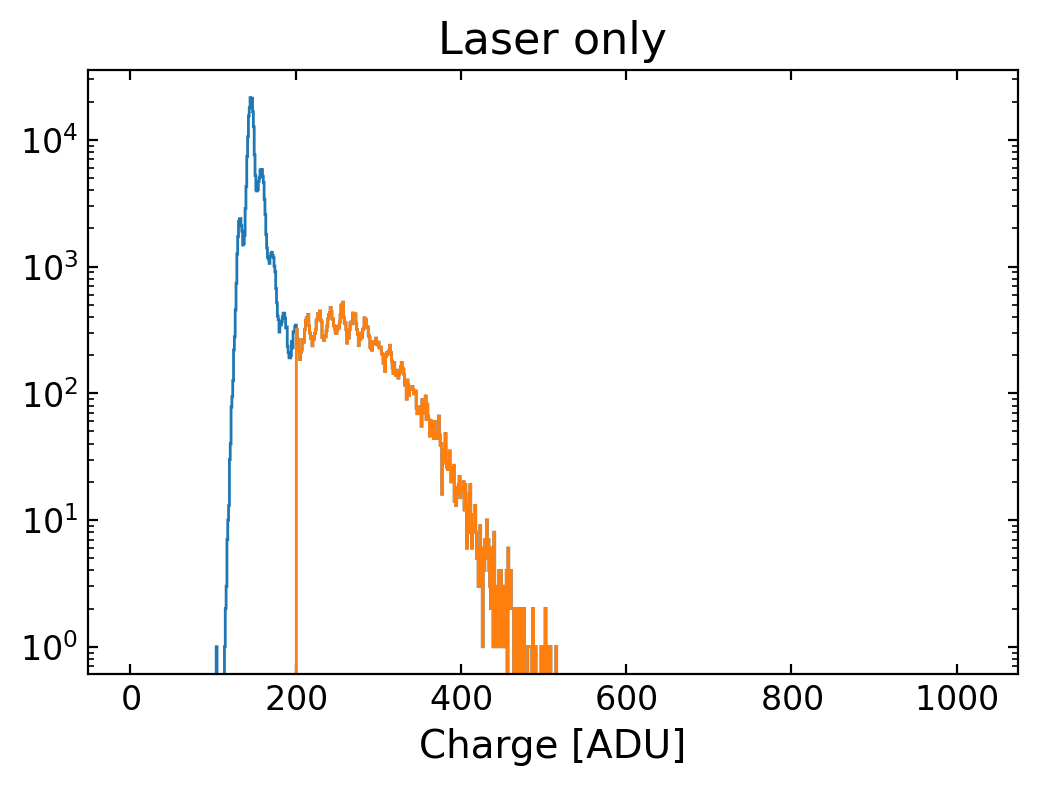

0.7143887334781694 [ns]


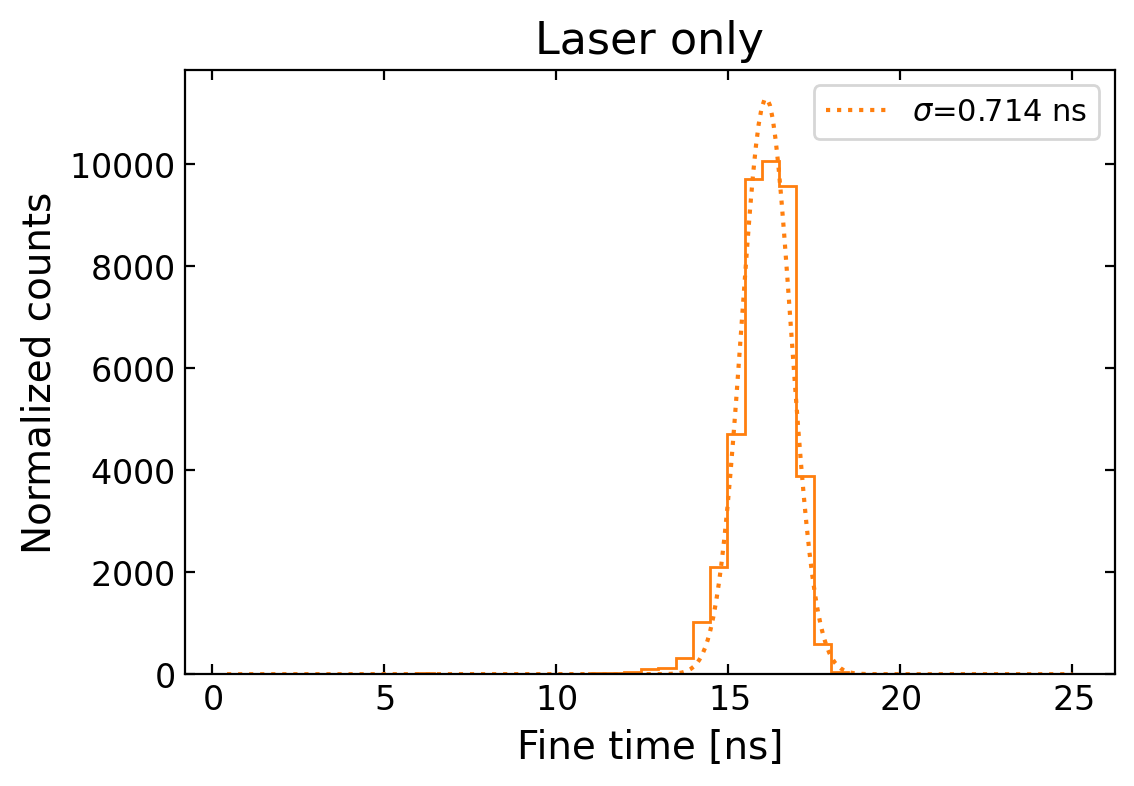

In [19]:
filename = f"{DATA_DIR}/19.data"
title_text= "Laser on WLS fiber"
plot_charge_time(filename, charge_cut_threshold=200, title_text=title_text, finetime_roll=7)

filename = f"{DATA_DIR}/17.data"
title_text= "Laser only"
plot_charge_time(filename, charge_cut_threshold=200, title_text=title_text, finetime_roll=7)

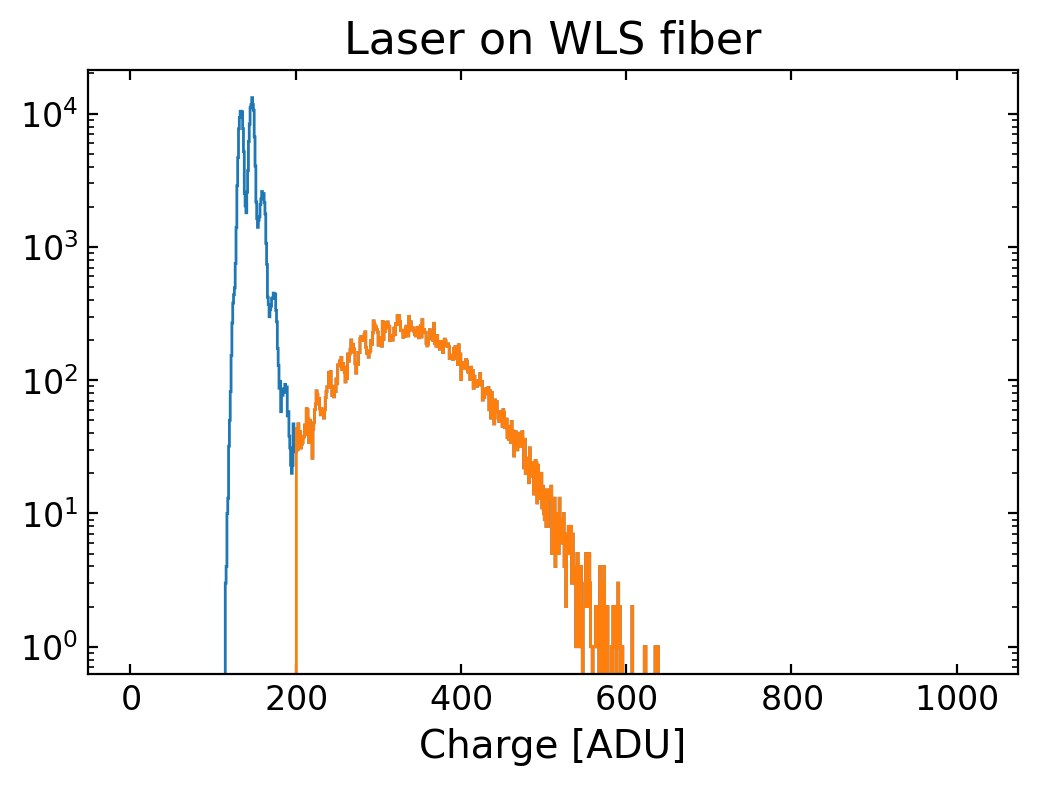

1.2199861962320244 [ns]


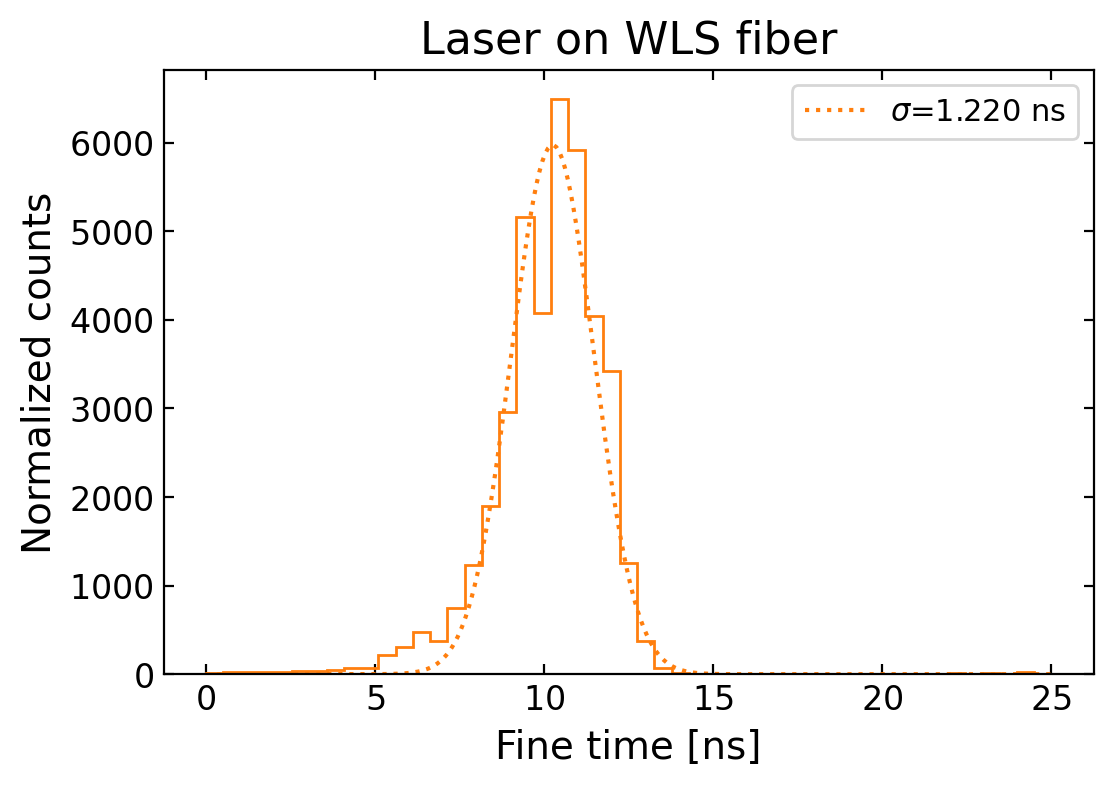

In [20]:
filename = f"{DATA_DIR}/22.data"
title_text= "Laser on WLS fiber"
plot_charge_time(filename, charge_cut_threshold=200, title_text=title_text, finetime_roll=7)

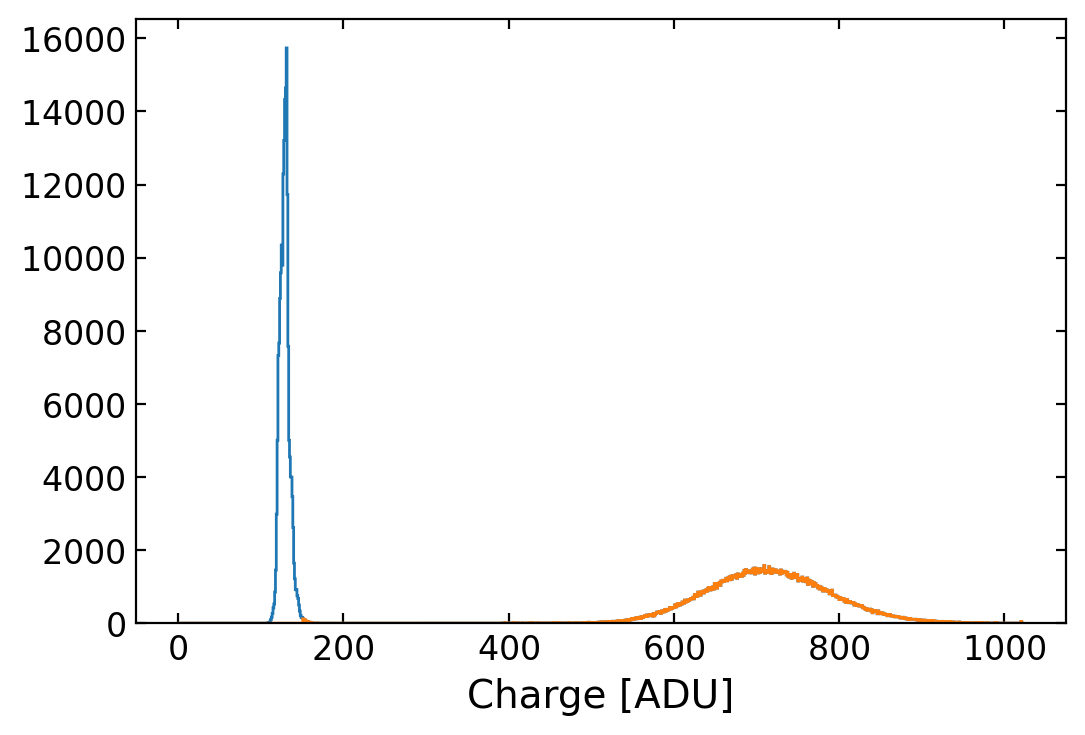

0.16900540192651278 [cm]


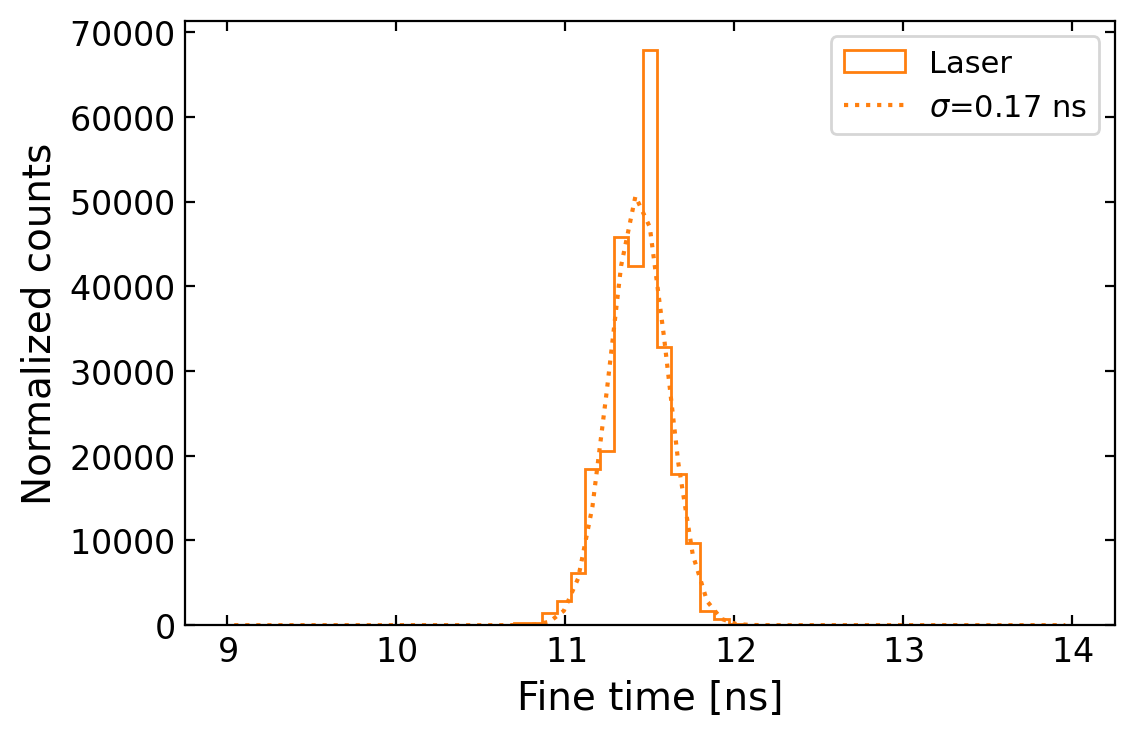

In [40]:
hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>150],bins=1023,range=(0,1023),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")
show()

# bins=np.linspace(0,25,240)
bins=np.linspace(9,14,60)

n,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>150], bins=bins,label="Laser", density=0, histtype="step", color="C1");
# n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<180], bins=bins,label="Dark current", density=1, histtype="step");
bincenters=0.5*(ibins[1:]+ibins[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(10,13))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[cm]')
plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.2f} ns" )
# plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

xlabel("Fine time [ns]")
ylabel("Normalized counts")
legend(fontsize=11)
# yscale("log")

In [9]:
filename = f"{DATA_DIR}/22.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])

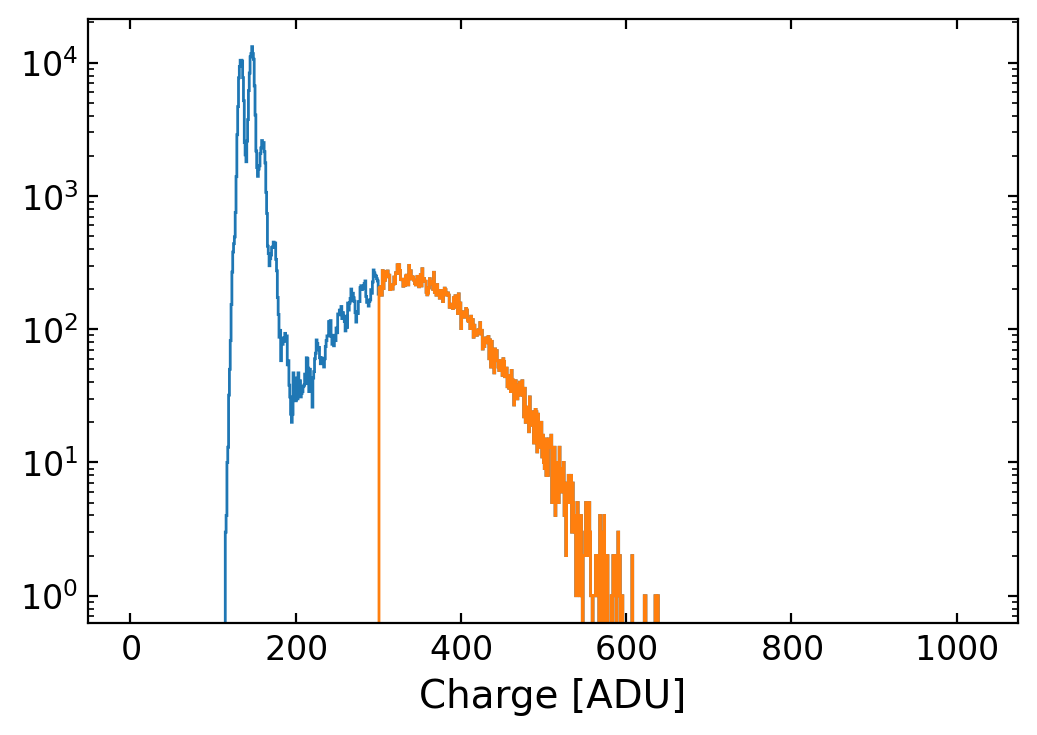

1.0989381395312532 [cm]


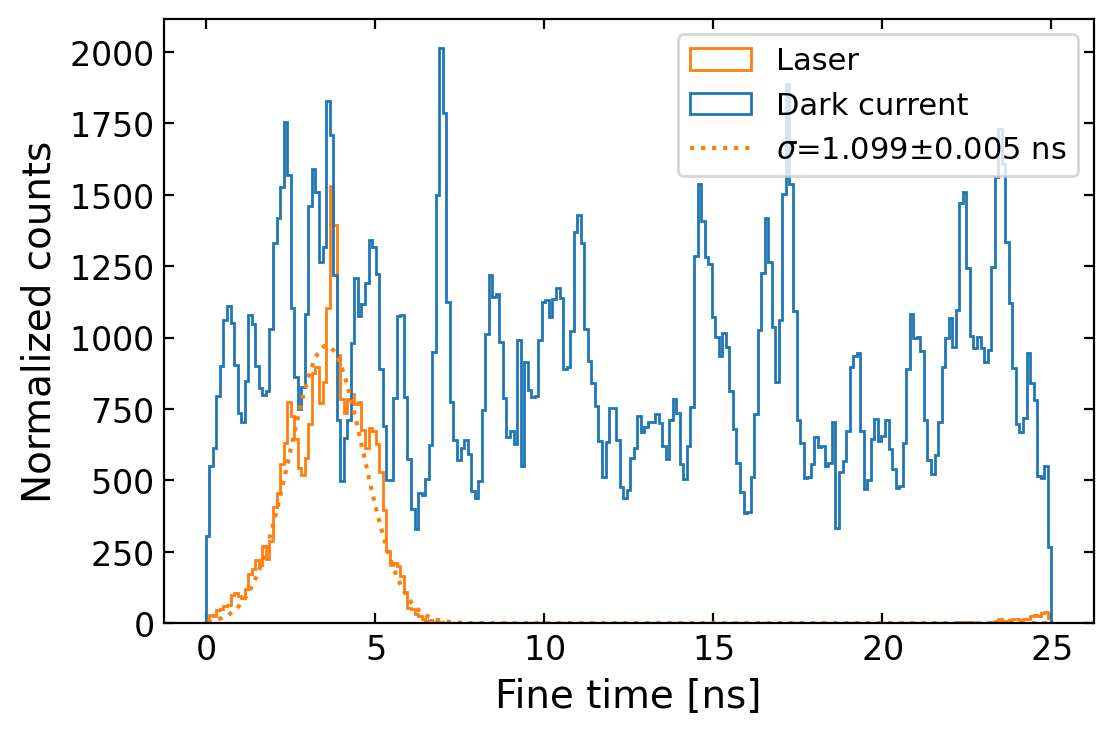

In [13]:
threshold=300

hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>threshold],bins=1023,range=(0,1023),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")
yscale("log")
show()

bins=np.linspace(0,25,240)
# bins=np.linspace(5,14,60)

n,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>threshold], bins=bins,label="Laser", density=0, histtype="step", color="C1");
n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
bincenters=0.5*(ibins[1:]+ibins[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(0,15))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[cm]')
plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f}$\pm${perr1[2]:.3f} ns" )
# plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

xlabel("Fine time [ns]")
ylabel("Normalized counts")
legend(fontsize=11)
# yscale("log")

In [ ]:
std(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>180])

---

In [9]:
files = ["4.data", "6.data", "11.data", "13.data"]

labels = ["Waveform Generator", "SiPM, Gain 820", "SiPM, Gain 420", "Waveform Generator, new"]

Data = []
ch=0
for filename in files:
    data  = pd.read_csv(f"{DATA_DIR}/{filename}", sep=';', on_bad_lines  = "skip", usecols=[f"CHARGE_{ch}", f"FINE_{ch}","RUN_EventTimecode_ns"])
    data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
    Data.append(data)
    

(0.0, 1050.0)

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


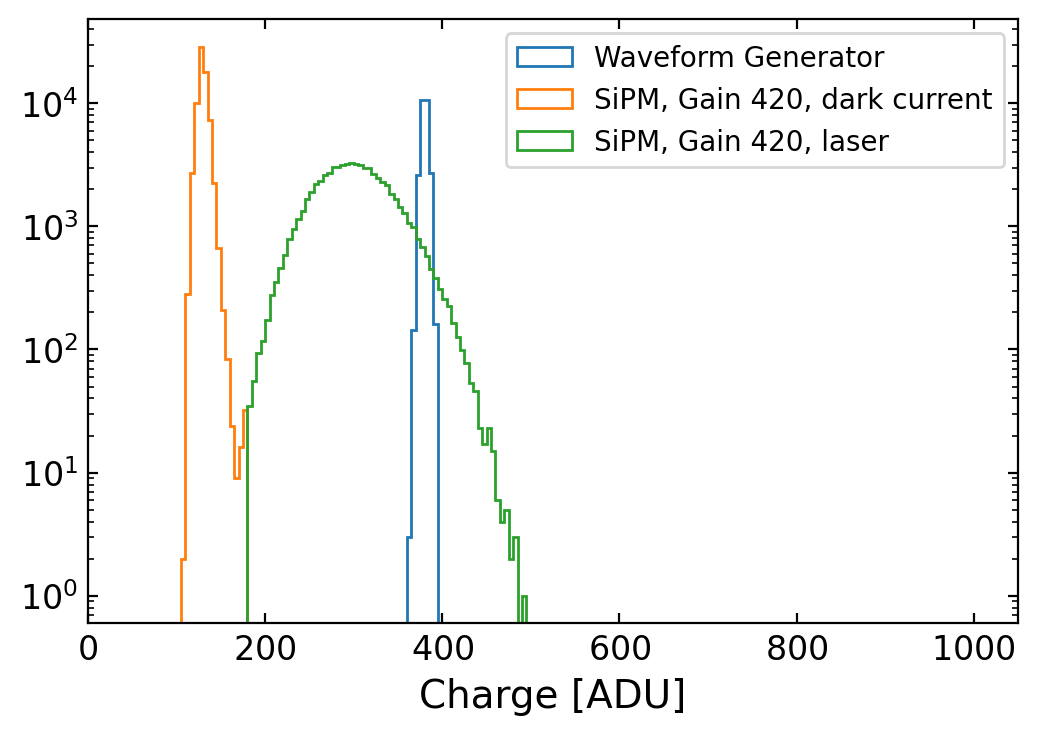

In [11]:
hist(Data[0].CHARGE_0[Data[0]["CHARGE_0"]>300],histtype="step",bins=200,range=(0,1000),label=labels[0]);
# hist(Data[1].CHARGE_0,histtype="step",bins=200,range=(0,1000),label=labels[1]+", dark current");
hist(Data[2].CHARGE_0[Data[2]["CHARGE_0"]<180],histtype="step",bins=200,range=(0,1000),label=labels[2]+", dark current");
hist(Data[2].CHARGE_0[Data[2]["CHARGE_0"]>180],histtype="step",bins=200,range=(0,1000),label=labels[2]+", laser");
# hist(Data[3].CHARGE_0[Data[2]["CHARGE_0"]>180],histtype="step",bins=200,range=(0,1000),label=labels[2]+", laser");
# hist(Data[2].CHARGE_0[data2["CHARGE_0"]>180],bins=100,range=(0,1000));
xlabel("Charge [ADU]")
yscale("log")
legend(fontsize=10)
xlim(0,)

Waveform Generator  std(n)=0.0050
SiPM, Gain 820, dark current  std(n)=499.0695
SiPM, Gain 420, dark current  std(n)=0.0116
SiPM, Gain 420, laser  std(n)=0.0048


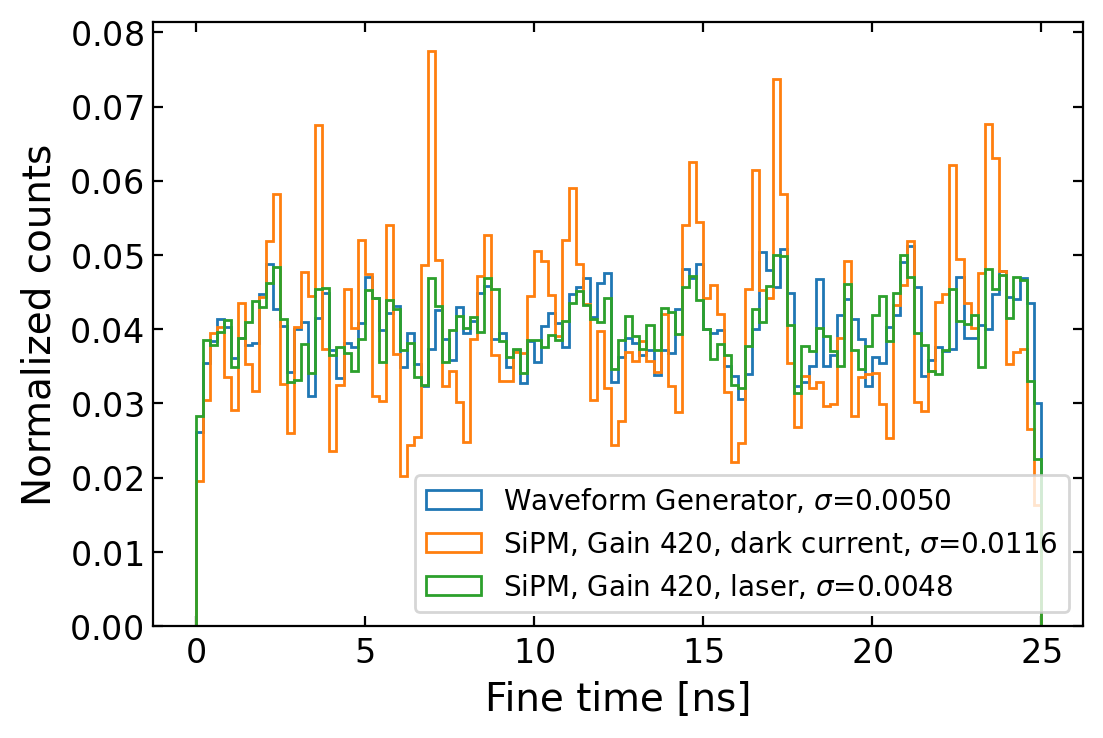

In [34]:
# FINE_21_calib = finetime_calib(data[f"FINE_{ch}"])
bins=np.linspace(0,25,121)

n0,ibins,_ = hist(Data[0][f"FINE_calib_{ch}"][Data[0]["CHARGE_0"]>300], bins=bins,label=labels[0], density=1, histtype="step");
# n1,ibins,_ = hist(Data[1][f"FINE_calib_{ch}"], bins=bins,label=labels[1]+", dark current", density=1, histtype="step");
n2,ibins,_ = hist(Data[2][f"FINE_calib_{ch}"][Data[2]["CHARGE_0"]<180], bins=bins,label=labels[2]+", dark current", density=1, histtype="step");
n3,ibins,_ = hist(Data[2][f"FINE_calib_{ch}"][Data[2]["CHARGE_0"]>180], bins=bins,label=labels[2]+", laser", density=1, histtype="step");
# n4,ibins,_ = hist(Data[3][f"FINE_calib_{ch}"][Data[2]["CHARGE_0"]>180], bins=bins,label=labels[3], density=1, histtype="step");

print(f"{labels[0]:<15}", f" std(n)={std(n0):.4f}")
print(f"{labels[1]}, dark current", f" std(n)={std(n1):.4f}")
print(f"{labels[2]}, dark current", f" std(n)={std(n2):.4f}")
print(f"{labels[2]}, laser", f" std(n)={std(n3):.4f}")
# print(f"{labels[3]}, laser", f" std(n)={std(n4):.4f}")


# bincenters = 0.5*(ibins[1:]+ibins[:-1])
# peak_inds = scipy.signal.find_peaks_cwt(n, [2,3], min_snr=1.2)
# print(peak_inds)
# for ipeak in range(2):
#     i0 = bincenters[peak_inds[ipeak]]
#     for i in range(4):
#         axvline(i0+25/4*i,color=f"C{ipeak+1}",linestyle="--")

        

xlabel("Fine time [ns]")
ylabel("Normalized counts")
handles, labels_this = gca().get_legend_handles_labels()
labels_this[0] = labels_this[0] + f", $\sigma$={std(n0):.4f}"
labels_this[1] = labels_this[1] + f", $\sigma$={std(n2):.4f}"
labels_this[2] = labels_this[2] + f", $\sigma$={std(n3):.4f}"
# labels_this[3] = labels_this[3] + f", $\sigma$={std(n3):.4f}"
legend(handles, labels_this, loc="lower right",fontsize=10)
# grid()

In [11]:
lines

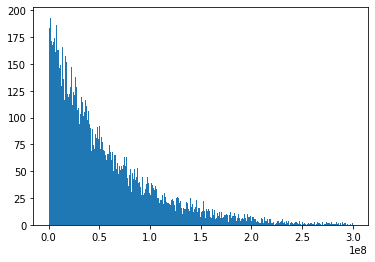

In [10]:
hist(np.diff(data["RUN_EventTimecode_ns"]),bins=300,range=(0,30e7));
# yscale("log")

In [6]:
# for i in range(len(config)):
#     print(f"#{i},", config[i])

In [ ]:
def replace_str_index(text,index=0,replacement=''):
    return '%s%s%s'%(text[:index],replacement,text[index+1:])

5: no fiber
6: with fiber, threshold 900
7: with fiber, threshold 970

In [35]:
filenames = {0: ["5.data", "No fiber"],
            1: ["6.data", "Threshold 900"],
             2: ["7.data", "Threshold 970"],
             3: ["8.data", "LED low, threshold 900"],
             4: ["10.data", "LED high, threshold 970"],
            5:["11.data", "Dark current, threshold 900"],
            6:["12.data", "LED high, threshold 900"]}

Data = {}
for key in filenames:
    filename = filenames[key][0]
    data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip")
    Data[key] = data

# ch = "21"
ch = "0"

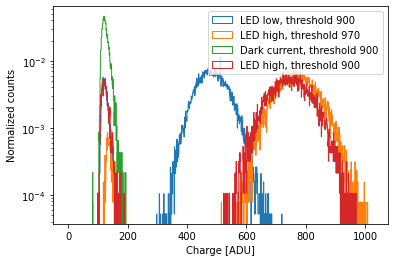

In [36]:
for key in filenames:
    if key<=2:
        continue
    data = Data[key]

    FINE_21_calib = data[f"CHARGE_{ch}"]
    bins=np.linspace(0,1024,1023)
    n,ibins,_ = hist(FINE_21_calib, bins=bins, histtype= "step", label = filenames[key][1], density=1);
    
legend()
xlabel("Charge [ADU]")
ylabel("Normalized counts")
yscale("log")

In [ ]:
for key in [5,3]:
    data = Data[key]

    FINE_21_calib = finetime_calib(data[f"FINE_{ch}"])
    bins=np.linspace(0,25,80)
    n,ibins,_ = hist(FINE_21_calib, bins=bins, color=f"C{key-3}", histtype= "step", label = filenames[key][1], density=1);
    print(filenames[key][1], f", std: {np.std(n)}")
    
legend()
xlabel("Fine time [ns]")
ylabel("Normalized counts")
show()

for key in [3,6,4]:
    data = Data[key]

    FINE_21_calib = finetime_calib(data[f"FINE_{ch}"])
    charge = data[f"CHARGE_{ch}"]
    bins=np.linspace(0,25,80)
    n,ibins,_ = hist(FINE_21_calib[charge>400], bins=bins, color=f"C{key-3}", histtype= "step", label = filenames[key][1], density=1);
    print(filenames[key][1], f", std: {np.std(n)}")
    
legend(loc=(1,0))
xlabel("Fine time [ns]")
ylabel("Normalized counts")

---

In [2]:
import h5py
import matplotlib.ticker as ticker

In [4]:
# DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"
# f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/preamp-out-default.h5', 'r')
# np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:])
# f.close()

array([-1823, -1296,  -852, ..., -1533, -1867, -1770], dtype=int16)

# ASIC A, preamp out 

In [3]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"

files = ["preamp-out-during-redout.h5",
         "preamp-out-default.h5",
"preamp-out-firmwaremod-2.h5",]

labels = ["During digital readout", "Digital readout stopped", "Clock disabled"]

Data = []
for filename in files:
    f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/{filename}', 'r')    
    Data.append(np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:]))
    f.close()

In [4]:
Data_fft=[]
for data in Data:
    Data_fft.append(np.fft.rfft(data))
freq = np.fft.rfftfreq(n=len(Data[0]),d=1/3_200_000_000)

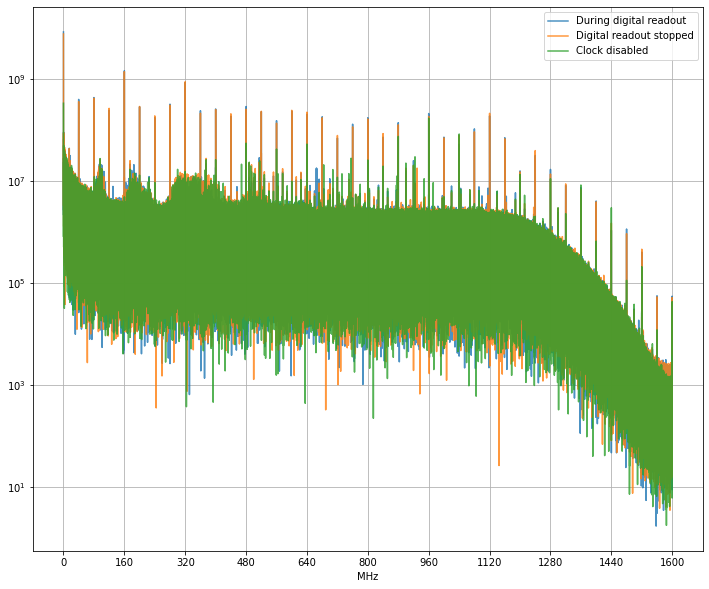

In [5]:
figure(figsize=(12,10))
for i, data_fft in enumerate(Data_fft):
    if i<2:
        plot(freq/1e6, np.abs(data_fft),alpha=0.8, label=labels[i])
    else:
        plot(freq/1e6, np.abs(data_fft)/2,alpha=0.8, label=labels[i])    
    
    
gca().xaxis.set_major_locator(ticker.MultipleLocator(160))    
grid()
xlabel("MHz")
yscale("log")
legend()

# ASIC A vs ASIC C

In [6]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"

files = ["preamp-out-default.h5","preamp-out-default-asic-c.h5",]

labels = ["ASIC A (with pitch adapter)","ASIC C (w/o pitch adapter)"]

Data = []
for filename in files:
    f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/{filename}', 'r')    
    Data.append(np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:]))
    f.close()

In [7]:
Data_fft=[]
for data in Data:
    Data_fft.append(np.fft.rfft(data))
freq = np.fft.rfftfreq(n=len(Data[0]),d=1/3_200_000_000)

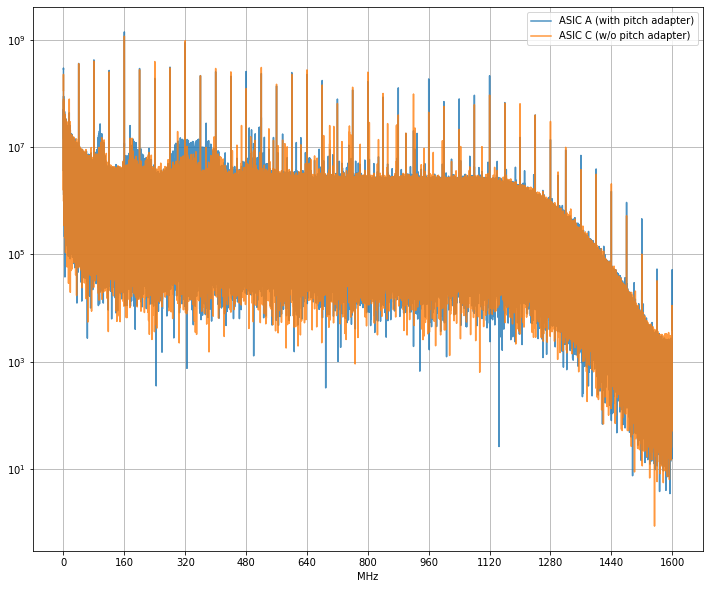

In [12]:
figure(figsize=(12,10))
for i, data_fft in enumerate(Data_fft):
    if i<2:
        plot(freq[1:]/1e6, np.abs(data_fft)[1:],alpha=0.8, label=labels[i])
    else:
        plot(freq[1:]/1e6, np.abs(data_fft)[1:]/2,alpha=0.8, label=labels[i])    
    
    
gca().xaxis.set_major_locator(ticker.MultipleLocator(160))    
grid()
xlabel("MHz")
yscale("log")
legend()
# xscale("log")

In [34]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"

files = ["time-threshold-during-readout.h5",
         "time-threshold-default.h5",
"time-threshold-firmwaremod.h5",]

Data = []
for filename in files:
    f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/{filename}', 'r')    
    Data.append(np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:]))
    f.close()

In [35]:
Data_fft=[]
for data in Data:
    Data_fft.append(np.fft.rfft(data))
freq = np.fft.rfftfreq(n=len(Data[0]),d=1/3_200_000_000)

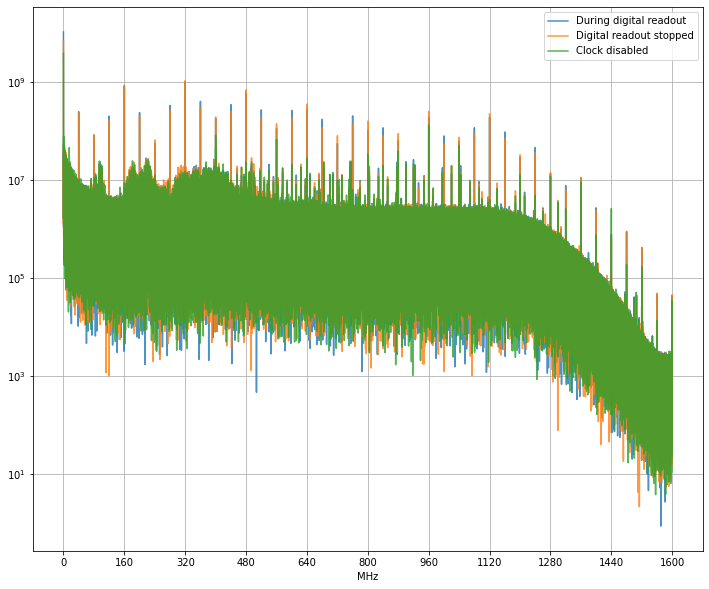

In [36]:
figure(figsize=(12,10))
for i, data_fft in enumerate(Data_fft):
    plot(freq/1e6, np.abs(data_fft),alpha=0.8, label=labels[i])
    
    
gca().xaxis.set_major_locator(ticker.MultipleLocator(160))    
grid()
xlabel("MHz")
yscale("log")
legend()